# Testing Action Recognition by image using Clip

In the Animal Kingdom dataset, action recognition is tested for unseen types of aniimals. Video clips of 6 action classes (moving, eating, attending, swimming, sensing, and keeping still). Then we select 4 animal types (birds, fishes, frogs, snakes) for training. Then we select 5 animal types for testing (lizards, primates, spiders, orthopteran insects, water fowls)

#### action indexes:
moving = 78 \
eating = 40 \
attending = 2 \
swimming = 123 \
sensing = 102 \
keeping still = 68

## Data Preparation

In [1]:
import pandas as pd
import csv
import json
from tqdm import tqdm

In [2]:
# go through pose estimation data to find the frames of animals for training and testing dataset that correspond with the correct classes

# the training and val subclasses data structures are organized where the key of the dict is the official subclass name found the in the data, and the value is the alias we will use for the clip model

training_subclasses = {
    "Bird": "bird",
    "Fish": "fish",
    "Frog / Toad": "frog",
    "Snake / Cobra / Viper / Python": "snake"
}

# spiders and orthopteran insects not found in Animal Kingdom dataset
val_subclasses = {
    "Lizard / Gecko / Draco / Iguana / Chamelon": "lizard",
    "Primate / Monkey / Macaque / Baboon / Chimpanzee / Gorilla / Orangutan / Langur": "primate",
    "Water bird / Duck / Swan / Goose": "water fowl"
}

all_data = []
f = open("/Users/jonathanlin/Documents/GitHub/research_transfer/datasets/Animal_Kingdom/pose_estimation/annotation/ak_P1/train.json", "r")
train_set = json.load(f)
f.close()
all_data = all_data + train_set
f = open("/Users/jonathanlin/Documents/GitHub/research_transfer/datasets/Animal_Kingdom/pose_estimation/annotation/ak_P1/test.json", "r")
test_set = json.load(f)
f.close()
all_data = all_data + test_set

# example data element
# {
    # ak_P1/0000: {
    #     image_subclass: penguin,
    #     dataset: train,
    #     action: 3
    # }
# }
data = {}

# add all the animals that are listed in the training or testing dataset
for i in range(len(all_data)):
    animal = all_data[i]
    if animal["animal_subclass"] in training_subclasses:
        # have to replace _f with _t because the PE images have _f while AR frames have _t. even tho it's the same image
        frame = animal["image"].replace("_f", "_t")
        data[frame] = {
            "image_subclass": training_subclasses[animal["animal_subclass"]],
            "dataset": "train"
        }
    if animal["animal_subclass"] in val_subclasses:
        # have to replace _f with _t because the PE images have _f while AR frames have _t. even tho it's the same image
        frame = animal["image"].replace("_f", "_t")
        data[frame] = {
            "image_subclass": val_subclasses[animal["animal_subclass"]],
            "dataset": "validation"
        }

In [3]:
valid_actions = ["78", "40", "2", "123", "102", "68"]

# create list of images from the training and testing set
csv_path = "/Users/jonathanlin/Documents/GitHub/research_transfer/datasets/Animal_Kingdom/action_recognition/annotation/train.csv"
frame_train = pd.read_csv(csv_path, delimiter=' ', skiprows=[0])
csv_path = "/Users/jonathanlin/Documents/GitHub/research_transfer/datasets/Animal_Kingdom/action_recognition/annotation/val.csv"
frame_val = pd.read_csv(csv_path, delimiter=' ', skiprows=[0])

combined_frame = pd.concat([frame_train, frame_val])

for row in combined_frame.itertuples(index=False):
    path = row[3]
    if path in data:
        action_indexes = row[4].split(",")
        # as per the paper, only include frames with 1 action
        if len(action_indexes) == 1:
            if action_indexes[0] in valid_actions:
                data[path]["action"] = action_indexes[0]

# delete all the frames that don't have an action
for key in list(data.keys()):
    if "action" not in data[key]:
        del data[key]

## Testing
`1` is True. `0` is False.

test for "a `{animal}` is `{action}`" for all combinatinos of subclasses and actions. example: "a dog is swimming"

In [4]:
confusion_matrix_indexes = ["moving", "eating", "attending", "swimming", "sensing", "keeping still"]

In [5]:
# create the strings using the above "a {animal} is {action}" format to be fed into CLIP

df = pd.read_excel("/Users/jonathanlin/Documents/GitHub/research_transfer/datasets/Animal_Kingdom/action_recognition/annotation/df_action.xlsx")

training_strings = []
val_strings = []

for subclass in training_subclasses:
    for action in valid_actions:
        training_strings.append(f"a {training_subclasses[subclass]} is {df.at[int(action), 'action'].lower()}")

for subclass in val_subclasses:
    for action in valid_actions:
        val_strings.append(f"a {val_subclasses[subclass]} is {df.at[int(action), 'action'].lower()}")

In [6]:
from PIL import Image
from transformers import CLIPProcessor, CLIPModel
import torch
import numpy as np
import matplotlib.pyplot as plt

model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

image_dir = "/Users/jonathanlin/Documents/GitHub/research_transfer/datasets/Animal_Kingdom/action_recognition/dataset/image/"

database_train_everything = {
    "bird": [],
    "fish": [],
    "frog": [],
    "snake": []
}
database_val_everything = {
    "lizard": [],
    "primate": [],
    "water fowl": []
}

database_actions_everything = {}

database_cm_everything_pred = []
database_cm_everything_true = []

for image_path, _ in tqdm(data.items()):
    label_num = data[image_path]["action"]
    full_image_path = image_dir + image_path
    
    correct_label = df.at[int(label_num), 'action'].lower()

    image = Image.open(full_image_path)

    inputs = None
    if data[image_path]["dataset"] == "train":
        inputs = processor(text=training_strings, images=image, return_tensors="pt", padding=True)
    else:
        inputs = processor(text=val_strings, images=image, return_tensors="pt", padding=True)

    outputs = model(**inputs)
    logits_per_image = outputs.logits_per_image  # this is the image-text similarity score
    probs = logits_per_image.softmax(dim=1)  # we can take the softmax to get the label probabilities
    index = torch.argmax(probs)

    # add stat for subclass accuracy stat
    if data[image_path]["dataset"] == "train":
        action = training_strings[index].split(" ")[-1]
        if action == "still":
            action = training_strings[index].split(" ")[-2] + " " + training_strings[index].split(" ")[-1]
        if action == correct_label:
            database_train_everything[data[image_path]["image_subclass"]].append(1)
        else:
            database_train_everything[data[image_path]["image_subclass"]].append(0)
    else:
        action = val_strings[index].split(" ")[-1]
        if action == "still":
            action = val_strings[index].split(" ")[-2] + " " + val_strings[index].split(" ")[-1]
        if action == correct_label:
            database_val_everything[data[image_path]["image_subclass"]].append(1)
        else:
            database_val_everything[data[image_path]["image_subclass"]].append(0)
    
    # add stat for action accuracy stat
    if correct_label not in database_actions_everything:
        database_actions_everything[correct_label] = []
    if action == correct_label:
        database_actions_everything[correct_label].append(1)
    else:
        database_actions_everything[correct_label].append(0)
    
    database_cm_everything_pred.append(action)
    database_cm_everything_true.append(correct_label)

100%|██████████| 7247/7247 [10:44<00:00, 11.24it/s]


In [7]:
# convert the dictionary values to percentages

database_train_everything_avg = []
for animal in database_train_everything:
    database_train_everything_avg += database_train_everything[animal]
    database_train_everything[animal] = database_train_everything[animal].count(1) / len(database_train_everything[animal])

database_val_everything_avg = []
for animal in database_val_everything:
    database_val_everything_avg += database_val_everything[animal]
    database_val_everything[animal] = database_val_everything[animal].count(1) / len(database_val_everything[animal])

database_actions_everything_avg = []
for action in database_actions_everything:
    database_actions_everything_avg += database_actions_everything[action]
    database_actions_everything[action] = database_actions_everything[action].count(1) / len(database_actions_everything[action])

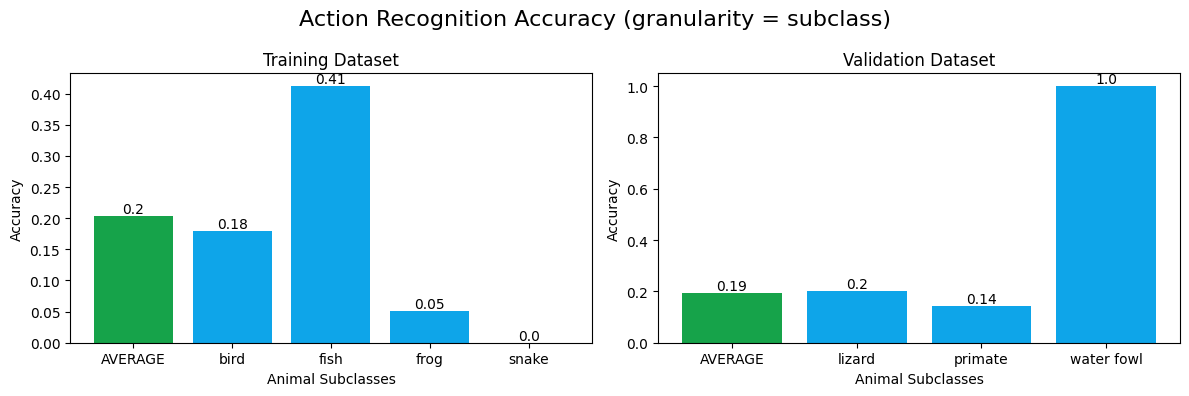

In [8]:
import matplotlib.pyplot as plt

categories1_everything = list(database_train_everything.keys())
values1_everything = list(database_train_everything.values())
categories1_everything.insert(0, "AVERAGE")
values1_everything.insert(0, database_train_everything_avg.count(1) / len(database_train_everything_avg))

categories2_everything = list(database_val_everything.keys())
values2_everything = list(database_val_everything.values())
categories2_everything.insert(0, "AVERAGE")
values2_everything.insert(0, database_val_everything_avg.count(1) / len(database_val_everything_avg))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Plot the first bar chart on the first subplot
ax1.bar(categories1_everything, values1_everything, color=["#16a34a", "#0ea5e9", "#0ea5e9", "#0ea5e9", "#0ea5e9"])
ax1.set_xlabel('Animal Subclasses')
ax1.set_ylabel('Accuracy')
ax1.set_title('Training Dataset')
for i, v in enumerate(values1_everything):
    ax1.text(i, v, str(round(v, 2)), ha='center', va='bottom')


# Plot the second bar chart on the second subplot
ax2.bar(categories2_everything, values2_everything, color=["#16a34a", "#0ea5e9", "#0ea5e9", "#0ea5e9"])
ax2.set_xlabel('Animal Subclasses')
ax2.set_ylabel('Accuracy')
ax2.set_title('Validation Dataset')
for i, v in enumerate(values2_everything):
    ax2.text(i, v, str(round(v, 2)), ha='center', va='bottom')

plt.suptitle('Action Recognition Accuracy (granularity = everything)', fontsize=16)

# Adjust the layout to avoid overlapping
plt.tight_layout()

# Show the plot
plt.show()

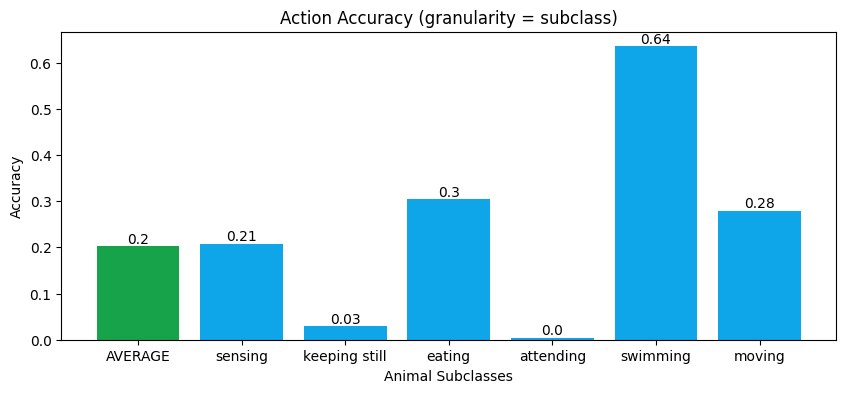

In [9]:
categories3_everything = list(database_actions_everything.keys())
values3_everything = list(database_actions_everything.values())
categories3_everything.insert(0, "AVERAGE")
values3_everything.insert(0, database_actions_everything_avg.count(1) / len(database_actions_everything_avg))

plt.figure(figsize=(10, 4))

plt.bar(categories3_everything, values3_everything, color=["#16a34a", "#0ea5e9", "#0ea5e9", "#0ea5e9", "#0ea5e9", "#0ea5e9", "#0ea5e9"])
plt.xlabel('Animal Subclasses')
plt.ylabel('Accuracy')
plt.title('Action Accuracy (granularity = subclass)')
for i, v in enumerate(values3_everything):
    plt.text(i, v, str(round(v, 2)), ha='center', va='bottom')

plt.show()

test for "a `{animal}` is `{action}`" but only the combinations of the specific animal and hand and all the other actions. example: "a dog is swimming"

In [34]:
# create the strings using the above "a {animal} is {action}" format to be fed into CLIP

df = pd.read_excel("/Users/jonathanlin/Documents/GitHub/research_transfer/datasets/Animal_Kingdom/action_recognition/annotation/df_action.xlsx")

training_strings = {}
val_strings = {}

for subclass in training_subclasses:
    training_strings[training_subclasses[subclass]] = []
    for action in valid_actions:
        training_strings[training_subclasses[subclass]].append(f"a {training_subclasses[subclass]} is {df.at[int(action), 'action'].lower()}")

for subclass in val_subclasses:
    val_strings[val_subclasses[subclass]] = []
    for action in valid_actions:
        val_strings[val_subclasses[subclass]].append(f"a {val_subclasses[subclass]} is {df.at[int(action), 'action'].lower()}")

In [37]:
from PIL import Image
from transformers import CLIPProcessor, CLIPModel
import torch
import numpy as np
import matplotlib.pyplot as plt

model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

image_dir = "/Users/jonathanlin/Documents/GitHub/research_transfer/datasets/Animal_Kingdom/action_recognition/dataset/image/"

database_train_subclass = {
    "bird": [],
    "fish": [],
    "frog": [],
    "snake": []
}
database_val_subclass = {
    "lizard": [],
    "primate": [],
    "water fowl": []
}

database_actions_subclass = {}

database_cm_subclass_pred = []
database_cm_subclass_true = []

for image_path, _ in tqdm(data.items()):
    label_num = data[image_path]["action"]
    full_image_path = image_dir + image_path

    subclass = data[image_path]["image_subclass"]
    
    correct_label = df.at[int(label_num), 'action'].lower()

    image = Image.open(full_image_path)

    inputs = None
    if data[image_path]["dataset"] == "train":
        inputs = processor(text=training_strings[subclass], images=image, return_tensors="pt", padding=True)
    else:
        inputs = processor(text=val_strings[subclass], images=image, return_tensors="pt", padding=True)

    outputs = model(**inputs)
    logits_per_image = outputs.logits_per_image  # this is the image-text similarity score
    probs = logits_per_image.softmax(dim=1)  # we can take the softmax to get the label probabilities
    index = torch.argmax(probs)

    # add stat for subclass accuracy stat
    if data[image_path]["dataset"] == "train":
        action = training_strings[subclass][index].split(" ")[-1]
        if action == "still":
            action = training_strings[subclass][index].split(" ")[-2] + " " + training_strings[subclass][index].split(" ")[-1]
        if action == correct_label:
            database_train_subclass[data[image_path]["image_subclass"]].append(1)
        else:
            database_train_subclass[data[image_path]["image_subclass"]].append(0)
    else:
        action = val_strings[subclass][index].split(" ")[-1]
        if action == "still":
            action = val_strings[subclass][index].split(" ")[-2] + " " + val_strings[subclass][index].split(" ")[-1]
        if action == correct_label:
            database_val_subclass[data[image_path]["image_subclass"]].append(1)
        else:
            database_val_subclass[data[image_path]["image_subclass"]].append(0)
    
    # add stat for action accuracy stat
    if correct_label not in database_actions_subclass:
        database_actions_subclass[correct_label] = []
    if action == correct_label:
        database_actions_subclass[correct_label].append(1)
    else:
        database_actions_subclass[correct_label].append(0)
    
    database_cm_subclass_pred.append(action)
    database_cm_subclass_true.append(correct_label)

100%|██████████| 7247/7247 [08:41<00:00, 13.89it/s]


In [38]:
# convert the dictionary values to percentages

database_train_subclass_avg = []
for animal in database_train_subclass:
    database_train_subclass_avg += database_train_subclass[animal]
    database_train_subclass[animal] = database_train_subclass[animal].count(1) / len(database_train_subclass[animal])

database_val_subclass_avg = []
for animal in database_val_subclass:
    database_val_subclass_avg += database_val_subclass[animal]
    database_val_subclass[animal] = database_val_subclass[animal].count(1) / len(database_val_subclass[animal])

database_actions_subclass_avg = []
for action in database_actions_subclass:
    database_actions_subclass_avg += database_actions_subclass[action]
    database_actions_subclass[action] = database_actions_subclass[action].count(1) / len(database_actions_subclass[action])

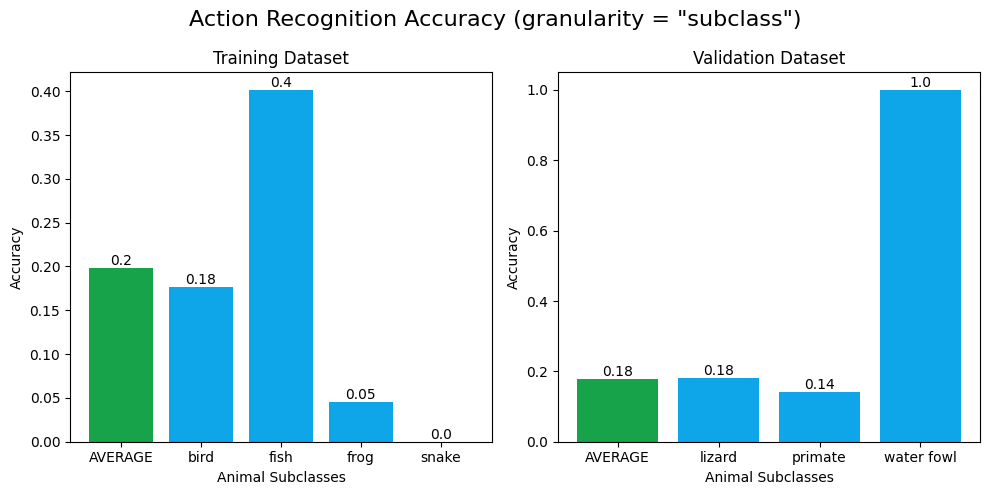

In [39]:
categories1_subclass = list(database_train_subclass.keys())
values1_subclass = list(database_train_subclass.values())
categories1_subclass.insert(0, "AVERAGE")
values1_subclass.insert(0, database_train_subclass_avg.count(1) / len(database_train_subclass_avg))

categories2_subclass = list(database_val_subclass.keys())
values2_subclass = list(database_val_subclass.values())
categories2_subclass.insert(0, "AVERAGE")
values2_subclass.insert(0, database_val_subclass_avg.count(1) / len(database_val_subclass_avg))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Plot the first bar chart on the first subplot
ax1.bar(categories1_subclass, values1_subclass, color=["#16a34a", "#0ea5e9", "#0ea5e9", "#0ea5e9", "#0ea5e9"])
ax1.set_xlabel('Animal Subclasses')
ax1.set_title('Training Dataset')
ax1.set_ylabel('Accuracy')
for i, v in enumerate(values1_subclass):
    ax1.text(i, v, str(round(v, 2)), ha='center', va='bottom')

# Plot the second bar chart on the second subplot
ax2.bar(categories2_subclass, values2_subclass, color=["#16a34a", "#0ea5e9", "#0ea5e9", "#0ea5e9"])
ax2.set_xlabel('Animal Subclasses')
ax2.set_ylabel('Accuracy')
ax2.set_title('Validation Dataset')
for i, v in enumerate(values2_subclass):
    ax2.text(i, v, str(round(v, 2)), ha='center', va='bottom')

plt.suptitle('Action Recognition Accuracy (granularity = "subclass")', fontsize=16)

# Adjust the layout to avoid overlapping
plt.tight_layout()

# Show the plot
plt.show()

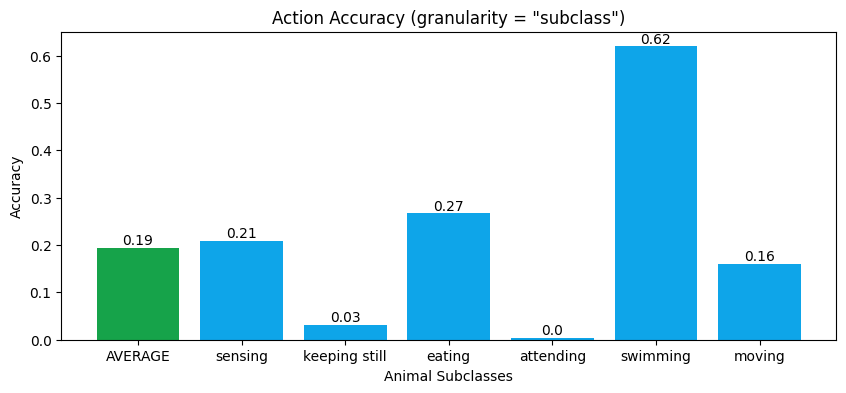

In [40]:
categories3_subclass = list(database_actions_subclass.keys())
values3_subclass = list(database_actions_subclass.values())
categories3_subclass.insert(0, "AVERAGE")
values3_subclass.insert(0, database_actions_subclass_avg.count(1) / len(database_actions_subclass_avg))

plt.figure(figsize=(10, 4))

plt.bar(categories3_subclass, values3_subclass, color=["#16a34a", "#0ea5e9", "#0ea5e9", "#0ea5e9", "#0ea5e9", "#0ea5e9", "#0ea5e9"])
plt.xlabel('Animal Subclasses')
plt.ylabel('Accuracy')
plt.title('Action Accuracy (granularity = "subclass")')
for i, v in enumerate(values3_subclass):
    plt.text(i, v, str(round(v, 2)), ha='center', va='bottom')

plt.show()

Now do action recognition and accuracy measuring for "an animal is `{action}`"

In [10]:
# create the strings using the above "an animal is {action}" format to be fed into CLIP

df = pd.read_excel("/Users/jonathanlin/Documents/GitHub/research_transfer/datasets/Animal_Kingdom/action_recognition/annotation/df_action.xlsx")

training_strings = []
val_strings = []


for action in valid_actions:
    training_strings.append(f"an animal is {df.at[int(action), 'action'].lower()}")

for action in valid_actions:
    val_strings.append(f"an animal is {df.at[int(action), 'action'].lower()}")

In [11]:
image_dir = "/Users/jonathanlin/Documents/GitHub/research_transfer/datasets/Animal_Kingdom/action_recognition/dataset/image/"

database_train_animal = {
    "bird": [],
    "fish": [],
    "frog": [],
    "snake": []
}
database_val_animal = {
    "lizard": [],
    "primate": [],
    "water fowl": []
}

database_actions_animal = {}

database_cm_animal_pred = []
database_cm_animal_true = []

for image_path, _ in tqdm(data.items()):
    label_num = data[image_path]["action"]
    full_image_path = image_dir + image_path
    
    correct_label = df.at[int(label_num), 'action'].lower()

    image = Image.open(full_image_path)

    inputs = None
    if data[image_path]["dataset"] == "train":
        inputs = processor(text=training_strings, images=image, return_tensors="pt", padding=True)
    else:
        inputs = processor(text=val_strings, images=image, return_tensors="pt", padding=True)

    outputs = model(**inputs)
    logits_per_image = outputs.logits_per_image  # this is the image-text similarity score
    probs = logits_per_image.softmax(dim=1)  # we can take the softmax to get the label probabilities
    index = torch.argmax(probs)

    if data[image_path]["dataset"] == "train":
        action = training_strings[index].split(" ")[-1]
        if action == "still":
            action = training_strings[index].split(" ")[-2] + " " + training_strings[index].split(" ")[-1]
        if action == correct_label:
            database_train_animal[data[image_path]["image_subclass"]].append(1)
        else:
            database_train_animal[data[image_path]["image_subclass"]].append(0)
    else:
        action = val_strings[index].split(" ")[-1]
        if action == "still":
            action = val_strings[index].split(" ")[-2] + " " + val_strings[index].split(" ")[-1]
        if action == correct_label:
            database_val_animal[data[image_path]["image_subclass"]].append(1)
        else:
            database_val_animal[data[image_path]["image_subclass"]].append(0)
    
    # add stat for action accuracy stat
    if correct_label not in database_actions_animal:
        database_actions_animal[correct_label] = []
    if action == correct_label:
        database_actions_animal[correct_label].append(1)
    else:
        database_actions_animal[correct_label].append(0)
    
    database_cm_animal_pred.append(action)
    database_cm_animal_true.append(correct_label)

100%|██████████| 7247/7247 [08:35<00:00, 14.05it/s]


In [12]:
# convert the dictionary values to percentages

database_train_animal_avg = []
for animal in database_train_animal:
    database_train_animal_avg += database_train_animal[animal]
    database_train_animal[animal] = database_train_animal[animal].count(1) / len(database_train_animal[animal])

database_val_animal_avg = []
for animal in database_val_animal:
    database_val_animal_avg += database_val_animal[animal]
    database_val_animal[animal] = database_val_animal[animal].count(1) / len(database_val_animal[animal])

database_actions_animal_avg = []
for action in database_actions_animal:
    database_actions_animal_avg += database_actions_animal[action]
    database_actions_animal[action] = database_actions_animal[action].count(1) / len(database_actions_animal[action])

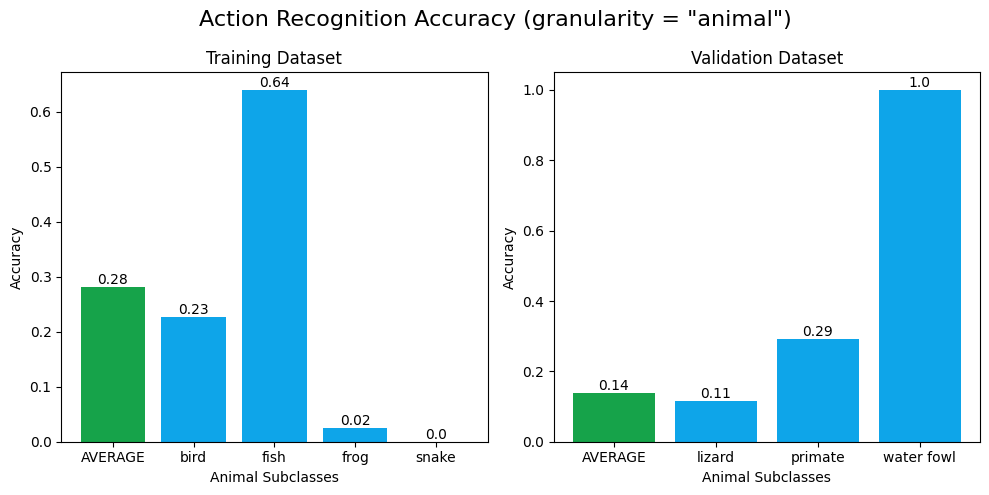

In [13]:
categories1_animal = list(database_train_animal.keys())
values1_animal = list(database_train_animal.values())
categories1_animal.insert(0, "AVERAGE")
values1_animal.insert(0, database_train_animal_avg.count(1) / len(database_train_animal_avg))

categories2_animal = list(database_val_animal.keys())
values2_animal = list(database_val_animal.values())
categories2_animal.insert(0, "AVERAGE")
values2_animal.insert(0, database_val_animal_avg.count(1) / len(database_val_animal_avg))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Plot the first bar chart on the first subplot
ax1.bar(categories1_animal, values1_animal, color=["#16a34a", "#0ea5e9", "#0ea5e9", "#0ea5e9", "#0ea5e9"])
ax1.set_xlabel('Animal Subclasses')
ax1.set_title('Training Dataset')
ax1.set_ylabel('Accuracy')
for i, v in enumerate(values1_animal):
    ax1.text(i, v, str(round(v, 2)), ha='center', va='bottom')

# Plot the second bar chart on the second subplot
ax2.bar(categories2_animal, values2_animal, color=["#16a34a", "#0ea5e9", "#0ea5e9", "#0ea5e9"])
ax2.set_xlabel('Animal Subclasses')
ax2.set_ylabel('Accuracy')
ax2.set_title('Validation Dataset')
for i, v in enumerate(values2_animal):
    ax2.text(i, v, str(round(v, 2)), ha='center', va='bottom')

plt.suptitle('Action Recognition Accuracy (granularity = "animal")', fontsize=16)

# Adjust the layout to avoid overlapping
plt.tight_layout()

# Show the plot
plt.show()

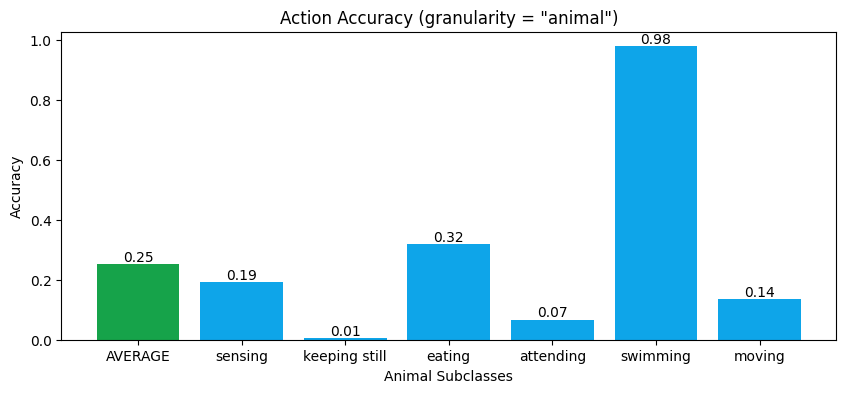

In [14]:
categories3_animal = list(database_actions_animal.keys())
values3_animal = list(database_actions_animal.values())
categories3_animal.insert(0, "AVERAGE")
values3_animal.insert(0, database_actions_animal_avg.count(1) / len(database_actions_animal_avg))

plt.figure(figsize=(10, 4))

plt.bar(categories3_animal, values3_animal, color=["#16a34a", "#0ea5e9", "#0ea5e9", "#0ea5e9", "#0ea5e9", "#0ea5e9", "#0ea5e9"])
plt.xlabel('Animal Subclasses')
plt.ylabel('Accuracy')
plt.title('Action Accuracy (granularity = "animal")')
for i, v in enumerate(values3_animal):
    plt.text(i, v, str(round(v, 2)), ha='center', va='bottom')

plt.show()

Now do action recognition and accuracy measuring for "`{action}`"

In [15]:
# create the strings using the above "{action}" format to be fed into CLIP

df = pd.read_excel("/Users/jonathanlin/Documents/GitHub/research_transfer/datasets/Animal_Kingdom/action_recognition/annotation/df_action.xlsx")

training_strings = []
val_strings = []


for action in valid_actions:
    training_strings.append(f"{df.at[int(action), 'action'].lower()}")

for action in valid_actions:
    val_strings.append(f"{df.at[int(action), 'action'].lower()}")

In [16]:
image_dir = "/Users/jonathanlin/Documents/GitHub/research_transfer/datasets/Animal_Kingdom/action_recognition/dataset/image/"

database_train_nothing = {
    "bird": [],
    "fish": [],
    "frog": [],
    "snake": []
}
database_val_nothing = {
    "lizard": [],
    "primate": [],
    "water fowl": []
}

database_actions_nothing = {}

database_cm_nothing_pred = []
database_cm_nothing_true = []

for image_path, _ in tqdm(data.items()):
    label_num = data[image_path]["action"]
    full_image_path = image_dir + image_path
    
    correct_label = df.at[int(label_num), 'action'].lower()

    image = Image.open(full_image_path)

    inputs = None
    if data[image_path]["dataset"] == "train":
        inputs = processor(text=training_strings, images=image, return_tensors="pt", padding=True)
    else:
        inputs = processor(text=val_strings, images=image, return_tensors="pt", padding=True)

    outputs = model(**inputs)
    logits_per_image = outputs.logits_per_image  # this is the image-text similarity score
    probs = logits_per_image.softmax(dim=1)  # we can take the softmax to get the label probabilities
    index = torch.argmax(probs)

    if data[image_path]["dataset"] == "train":
        action = training_strings[index].split(" ")[-1]
        if action == "still":
            action = training_strings[index].split(" ")[-2] + " " + training_strings[index].split(" ")[-1]
        if action == correct_label:
            database_train_nothing[data[image_path]["image_subclass"]].append(1)
        else:
            database_train_nothing[data[image_path]["image_subclass"]].append(0)
    else:
        action = val_strings[index].split(" ")[-1]
        if action == "still":
            action = val_strings[index].split(" ")[-2] + " " + val_strings[index].split(" ")[-1]
        if action == correct_label:
            database_val_nothing[data[image_path]["image_subclass"]].append(1)
        else:
            database_val_nothing[data[image_path]["image_subclass"]].append(0)
    
    # add stat for action accuracy stat
    if correct_label not in database_actions_nothing:
        database_actions_nothing[correct_label] = []
    if action == correct_label:
        database_actions_nothing[correct_label].append(1)
    else:
        database_actions_nothing[correct_label].append(0)
    
    database_cm_nothing_pred.append(action)
    database_cm_nothing_true.append(correct_label)

100%|██████████| 7247/7247 [08:21<00:00, 14.45it/s]


In [17]:
# convert the dictionary values to percentages

database_train_nothing_avg = []
for animal in database_train_nothing:
    database_train_nothing_avg += database_train_nothing[animal]
    database_train_nothing[animal] = database_train_nothing[animal].count(1) / len(database_train_nothing[animal])

database_val_nothing_avg = []
for animal in database_val_nothing:
    database_val_nothing_avg += database_val_nothing[animal]
    database_val_nothing[animal] = database_val_nothing[animal].count(1) / len(database_val_nothing[animal])

database_action_nothing_avg = []
for action in database_actions_nothing:
    database_action_nothing_avg += database_actions_nothing[action]
    database_actions_nothing[action] = database_actions_nothing[action].count(1) / len(database_actions_nothing[action])

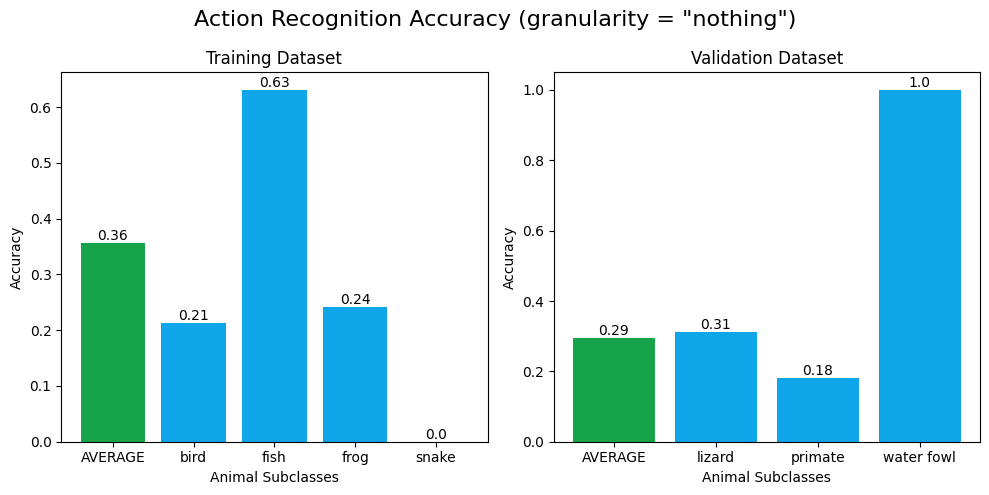

In [18]:
categories1_nothing = list(database_train_nothing.keys())
values1_nothing = list(database_train_nothing.values())
categories1_nothing.insert(0, "AVERAGE")
values1_nothing.insert(0, database_train_nothing_avg.count(1) / len(database_train_nothing_avg))

categories2_nothing = list(database_val_nothing.keys())
values2_nothing = list(database_val_nothing.values())
categories2_nothing.insert(0, "AVERAGE")
values2_nothing.insert(0, database_val_nothing_avg.count(1) / len(database_val_nothing_avg))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Plot the first bar chart on the first subplot
ax1.bar(categories1_nothing, values1_nothing, color=["#16a34a", "#0ea5e9", "#0ea5e9", "#0ea5e9", "#0ea5e9"])
ax1.set_xlabel('Animal Subclasses')
ax1.set_title('Training Dataset')
ax1.set_ylabel('Accuracy')
for i, v in enumerate(values1_nothing):
    ax1.text(i, v, str(round(v, 2)), ha='center', va='bottom')

# Plot the second bar chart on the second subplot
ax2.bar(categories2_nothing, values2_nothing, color=["#16a34a", "#0ea5e9", "#0ea5e9", "#0ea5e9"])
ax2.set_xlabel('Animal Subclasses')
ax2.set_ylabel('Accuracy')
ax2.set_title('Validation Dataset')
for i, v in enumerate(values2_nothing):
    ax2.text(i, v, str(round(v, 2)), ha='center', va='bottom')

plt.suptitle('Action Recognition Accuracy (granularity = "nothing")', fontsize=16)

# Adjust the layout to avoid overlapping
plt.tight_layout()

# Show the plot
plt.show()

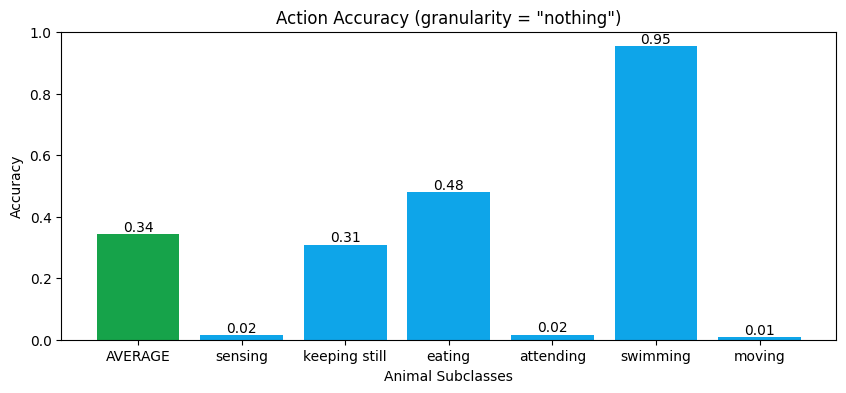

In [19]:
categories3_nothing = list(database_actions_nothing.keys())
values3_nothing = list(database_actions_nothing.values())
categories3_nothing.insert(0, "AVERAGE")
values3_nothing.insert(0, database_action_nothing_avg.count(1) / len(database_action_nothing_avg))

plt.figure(figsize=(10, 4))

plt.bar(categories3_nothing, values3_nothing, color=["#16a34a", "#0ea5e9", "#0ea5e9", "#0ea5e9", "#0ea5e9", "#0ea5e9", "#0ea5e9"])
plt.xlabel('Animal Subclasses')
plt.ylabel('Accuracy')
plt.title('Action Accuracy (granularity = "nothing")')
for i, v in enumerate(values3_nothing):
    plt.text(i, v, str(round(v, 2)), ha='center', va='bottom')

plt.show()

# Plot Everything

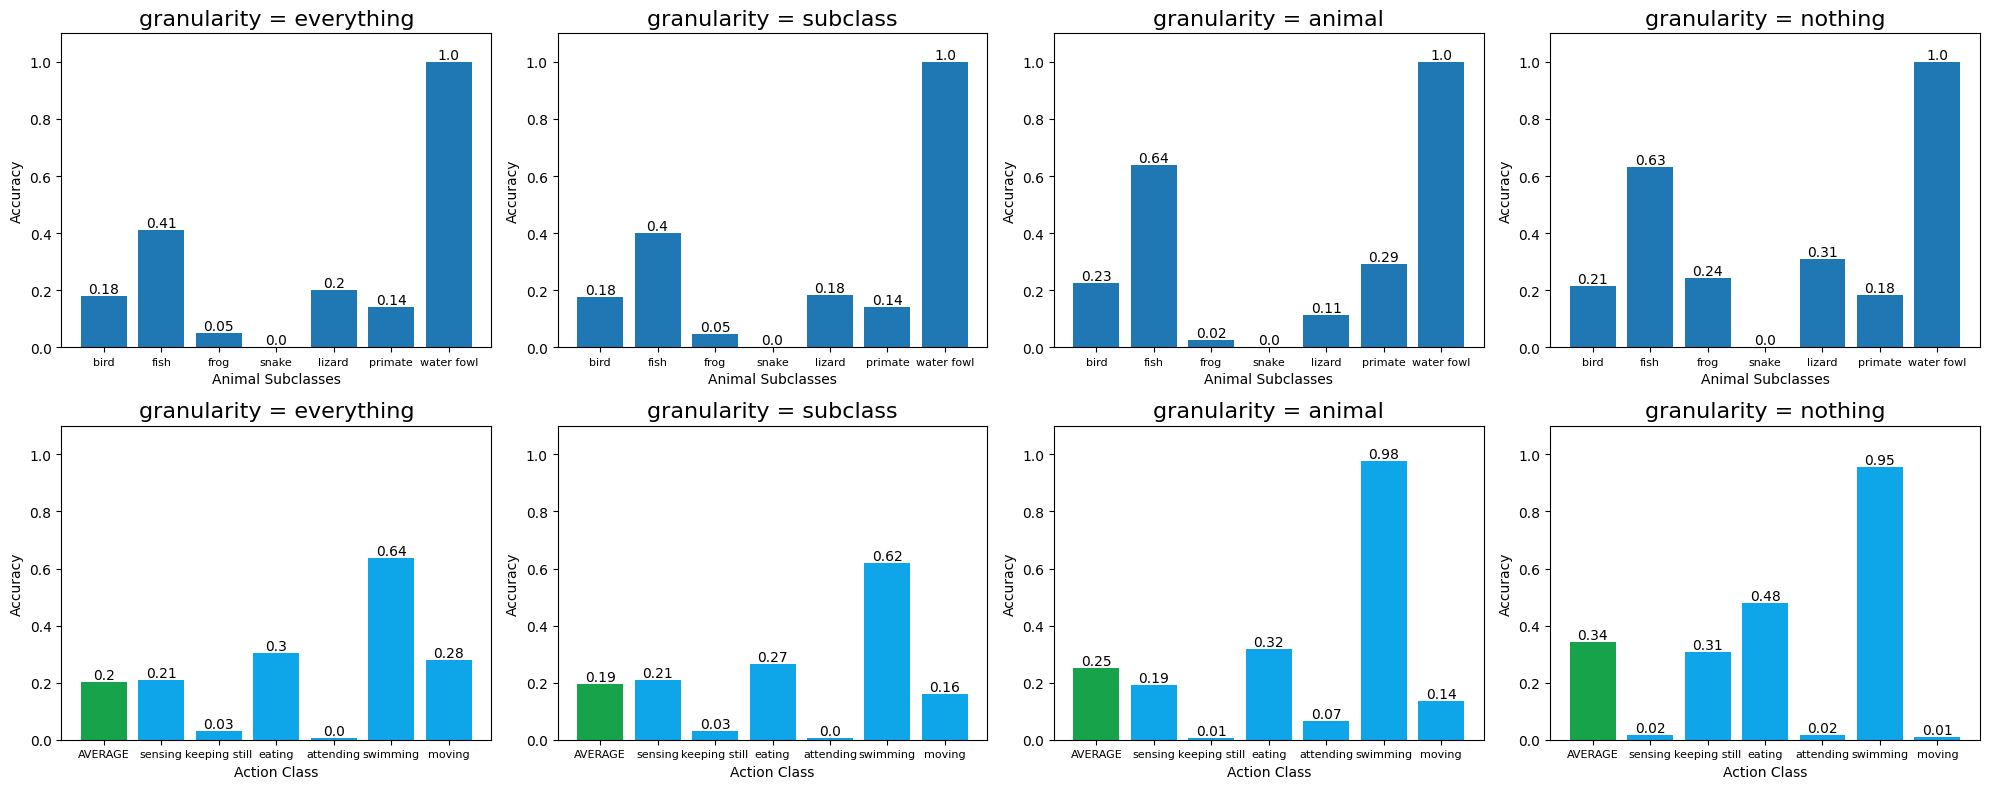

In [47]:
import matplotlib.pyplot as plt

fig, ((ax1, ax2, ax3, ax4), (ax5, ax6, ax7, ax8)) = plt.subplots(2, 4, figsize=(20, 8))

ax1.bar(categories1_everything[1:] + categories2_everything[1:], values1_everything[1:] + values2_everything[1:])
ax1.set_xlabel('Animal Subclasses')
ax1.set_ylabel('Accuracy')
ax1.set_title('granularity = everything', fontsize=16)
ax1.tick_params(axis='x', labelsize=8)
for i, v in enumerate(values1_everything[1:] + values2_everything[1:]):
    ax1.text(i, v, str(round(v, 2)), ha='center', va='bottom')

ax2.bar(categories1_subclass[1:] + categories2_subclass[1:], values1_subclass[1:] + values2_subclass[1:])
ax2.set_xlabel('Animal Subclasses')
ax2.set_ylabel('Accuracy')
ax2.set_title('granularity = subclass', fontsize=16)
ax2.tick_params(axis='x', labelsize=8)
for i, v in enumerate(values1_subclass[1:] + values2_subclass[1:]):
    ax2.text(i, v, str(round(v, 2)), ha='center', va='bottom')

ax3.bar(categories1_animal[1:] + categories2_animal[1:], values1_animal[1:] + values2_animal[1:])
ax3.set_xlabel('Animal Subclasses')
ax3.set_ylabel('Accuracy')
ax3.set_title('granularity = animal', fontsize=16)
ax3.tick_params(axis='x', labelsize=8)
for i, v in enumerate(values1_animal[1:] + values2_animal[1:]):
    ax3.text(i, v, str(round(v, 2)), ha='center', va='bottom')

ax4.bar(categories1_nothing[1:] + categories2_nothing[1:], values1_nothing[1:] + values2_nothing[1:])
ax4.set_xlabel('Animal Subclasses')
ax4.set_ylabel('Accuracy')
ax4.set_title('granularity = nothing', fontsize=16)
ax4.tick_params(axis='x', labelsize=8)
for i, v in enumerate(values1_nothing[1:] + values2_nothing[1:]):
    ax4.text(i, v, str(round(v, 2)), ha='center', va='bottom')


# plot the second row (accuracy categorized by action)

ax5.bar(categories3_everything, values3_everything, color=["#16a34a", "#0ea5e9", "#0ea5e9", "#0ea5e9", "#0ea5e9", "#0ea5e9", "#0ea5e9"])
ax5.set_xlabel('Action Class')
ax5.set_ylabel('Accuracy')
ax5.set_title('granularity = everything', fontsize=16)
ax5.tick_params(axis='x', labelsize=8)
for i, v in enumerate(values3_everything):
    ax5.text(i, v, str(round(v, 2)), ha='center', va='bottom')

ax6.bar(categories3_subclass, values3_subclass, color=["#16a34a", "#0ea5e9", "#0ea5e9", "#0ea5e9", "#0ea5e9", "#0ea5e9", "#0ea5e9"])
ax6.set_xlabel('Action Class')
ax6.set_ylabel('Accuracy')
ax6.set_title('granularity = subclass', fontsize=16)
ax6.tick_params(axis='x', labelsize=8)
for i, v in enumerate(values3_subclass):
    ax6.text(i, v, str(round(v, 2)), ha='center', va='bottom')

ax7.bar(categories3_animal, values3_animal, color=["#16a34a", "#0ea5e9", "#0ea5e9", "#0ea5e9", "#0ea5e9", "#0ea5e9", "#0ea5e9"])
ax7.set_xlabel('Action Class')
ax7.set_ylabel('Accuracy')
ax7.set_title('granularity = animal', fontsize=16)
ax7.tick_params(axis='x', labelsize=8)
for i, v in enumerate(values3_animal):
    ax7.text(i, v, str(round(v, 2)), ha='center', va='bottom')

ax8.bar(categories3_nothing, values3_nothing, color=["#16a34a", "#0ea5e9", "#0ea5e9", "#0ea5e9", "#0ea5e9", "#0ea5e9", "#0ea5e9"])
ax8.set_xlabel('Action Class')
ax8.set_ylabel('Accuracy')
ax8.set_title('granularity = nothing', fontsize=16)
ax8.tick_params(axis='x', labelsize=8)
for i, v in enumerate(values3_nothing):
    ax8.text(i, v, str(round(v, 2)), ha='center', va='bottom')

ax1.set_ylim(0, 1.1)
ax2.set_ylim(0, 1.1)
ax3.set_ylim(0, 1.1)
ax4.set_ylim(0, 1.1)
ax5.set_ylim(0, 1.1)
ax6.set_ylim(0, 1.1)
ax7.set_ylim(0, 1.1)
ax8.set_ylim(0, 1.1)

# Adjust the layout to avoid overlapping
plt.tight_layout()

# Show the plot
plt.show()

# Confusion Matrices

In [21]:
for i in range(len(database_cm_everything_pred)):
    database_cm_everything_pred[i] = confusion_matrix_indexes.index(database_cm_everything_pred[i])
    database_cm_everything_true[i] = confusion_matrix_indexes.index(database_cm_everything_true[i])
for i in range(len(database_cm_subclass_pred)):
    database_cm_subclass_pred[i] = confusion_matrix_indexes.index(database_cm_subclass_pred[i])
    database_cm_subclass_true[i] = confusion_matrix_indexes.index(database_cm_subclass_true[i])
for i in range(len(database_cm_animal_pred)):
    database_cm_animal_pred[i] = confusion_matrix_indexes.index(database_cm_animal_pred[i])
    database_cm_animal_true[i] = confusion_matrix_indexes.index(database_cm_animal_true[i])
for i in range(len(database_cm_nothing_pred)):
    database_cm_nothing_pred[i] = confusion_matrix_indexes.index(database_cm_nothing_pred[i])
    database_cm_nothing_true[i] = confusion_matrix_indexes.index(database_cm_nothing_true[i])

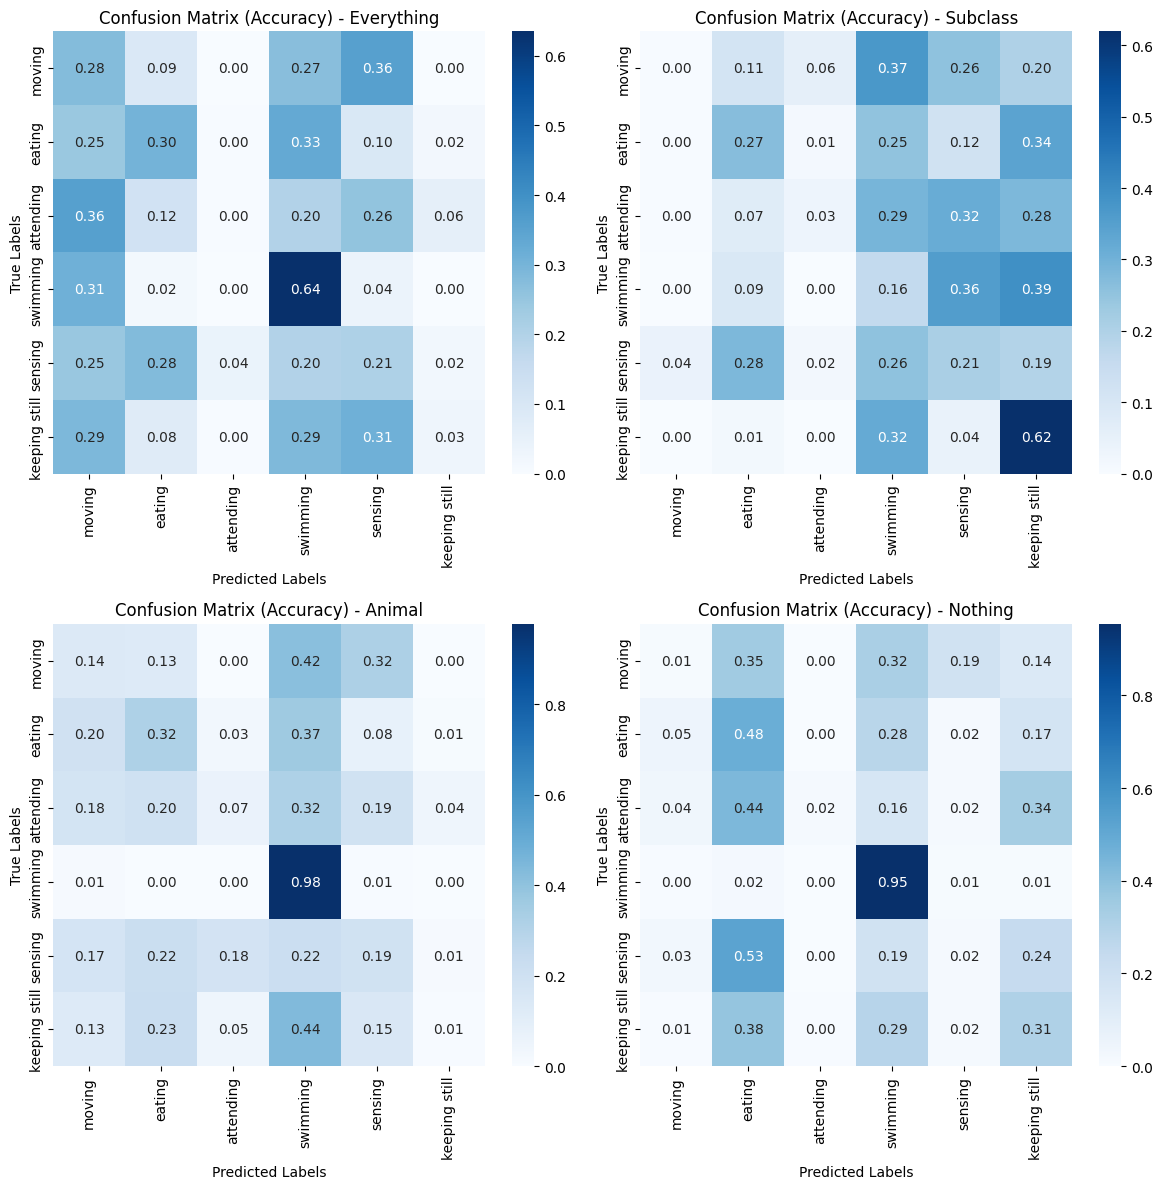

In [46]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Create the confusion matrices
cm1 = confusion_matrix(database_cm_everything_true, database_cm_everything_pred)
cm2 = confusion_matrix(database_cm_subclass_true, database_cm_subclass_pred)
cm3 = confusion_matrix(database_cm_animal_true, database_cm_animal_pred)
cm4 = confusion_matrix(database_cm_nothing_true, database_cm_nothing_pred)

# Calculate accuracy for each class and normalize the confusion matrices
class_accuracy1 = cm1.astype('float') / cm1.sum(axis=1)[:, np.newaxis]
class_accuracy2 = cm2.astype('float') / cm2.sum(axis=1)[:, np.newaxis]
class_accuracy3 = cm3.astype('float') / cm3.sum(axis=1)[:, np.newaxis]
class_accuracy4 = cm4.astype('float') / cm4.sum(axis=1)[:, np.newaxis]

# Create subplots with 1 row and 3 columns
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 12))

# Plot the first heatmap
sns.heatmap(class_accuracy1, annot=True, cmap='Blues', fmt='.2f', xticklabels=confusion_matrix_indexes, yticklabels=confusion_matrix_indexes, ax=ax1)
ax1.set_xlabel('Predicted Labels')
ax1.set_ylabel('True Labels')
ax1.set_title('Confusion Matrix (Accuracy) - Everything')

# Plot the second heatmap
sns.heatmap(class_accuracy2, annot=True, cmap='Blues', fmt='.2f', xticklabels=confusion_matrix_indexes, yticklabels=confusion_matrix_indexes, ax=ax2)
ax2.set_xlabel('Predicted Labels')
ax2.set_ylabel('True Labels')
ax2.set_title('Confusion Matrix (Accuracy) - Subclass')

# Plot the third heatmap
sns.heatmap(class_accuracy3, annot=True, cmap='Blues', fmt='.2f', xticklabels=confusion_matrix_indexes, yticklabels=confusion_matrix_indexes, ax=ax3)
ax3.set_xlabel('Predicted Labels')
ax3.set_ylabel('True Labels')
ax3.set_title('Confusion Matrix (Accuracy) - Animal')

# Plot the fourth heatmap
sns.heatmap(class_accuracy4, annot=True, cmap='Blues', fmt='.2f', xticklabels=confusion_matrix_indexes, yticklabels=confusion_matrix_indexes, ax=ax4)
ax4.set_xlabel('Predicted Labels')
ax4.set_ylabel('True Labels')
ax4.set_title('Confusion Matrix (Accuracy) - Nothing')

# Adjust the layout to avoid overlapping
plt.tight_layout()

# Show the plot
plt.show()